Nama: Achmad Bauravindah

Email: baurav99@gmail.com

Asal: Pasuruan, Jawa Timur

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger # Callback
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### Download data

In [2]:
# # Download data from kaggle 
# _ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
# _ = ! pip install kaggle # install kaggle on drevice
# _ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
# _ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
# _ = ! chmod 600 ~/.kaggle/kaggle.json # change access
# _ = ! kaggle datasets download general-electric-company-dataset # which dataset to download
# _ = ! unzip general-electric-company-dataset # unzip if data zipped

### Get Data from directory

In [55]:
# Get data from direktori
data_path = 'historical-gold-data.xlsx'
data = pd.read_excel(data_path)

### Show Data
- Price column will be taken to predict "Future Gold Price"
- Price column contain price in Dollar ($)
- Price column is in 100gr of gold
- So this column will change to Rupiah and divided by 100gr to get price in 1gr gold

In [56]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/31/1984,311.7,311.70,311.70,311.70,NaN,-0.10%
1,12/28/1984,312.0,312.00,312.00,312.00,NaN,0.91%
2,12/27/1984,309.2,310.50,312.00,307.30,20.43K,-1.59%
3,12/26/1984,314.2,313.80,315.60,313.50,10.94K,0.32%
4,12/21/1984,313.2,313.00,315.00,310.60,19.46K,1.16%


### Show count data

In [57]:
# Jumlah data
data.count()

Date        12226
Price       12226
Open        12226
High        12226
Low         12226
Vol.         9546
Change %    12226
dtype: int64

### Change Data Column to Date Index in Pandas

In [58]:
# Set index dates to data
data["Date"] = pd.to_datetime(data.Date, dayfirst=True)
data.set_index("Date", inplace=True)

/var/folders/6d/2cbwyd4j7wxby3pmr1z_84s40000gn/T/ipykernel_83288/2734982431.py:2: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data["Date"] = pd.to_datetime(data.Date, dayfirst=True)


### Add Day Date with NaN Date Values
(Because the data is incomplete in every date columns (there is missing value))

In [59]:
data_new = data.reindex(pd.date_range('1985-01-01', '2023-03-14'))

### Create price_data Dataframe from Price Column

In [60]:
price_data = data_new['Price']

### Calculate NaN Price Values

In [65]:
print("NaN: ", price_data.isna().sum())

NaN:  0


### Impute Missing Values (Price) with 'Rows After' or 'Before Values' Data

In [64]:
price_data = price_data.fillna(method='ffill') # Interpolate NaN data (based on before and after value)
price_data[0] = price_data[1] # First data can't to interpolate, so this is to rise it
print("NaN: ", price_data.isna().sum())


NaN:  0


### Plot Dataset

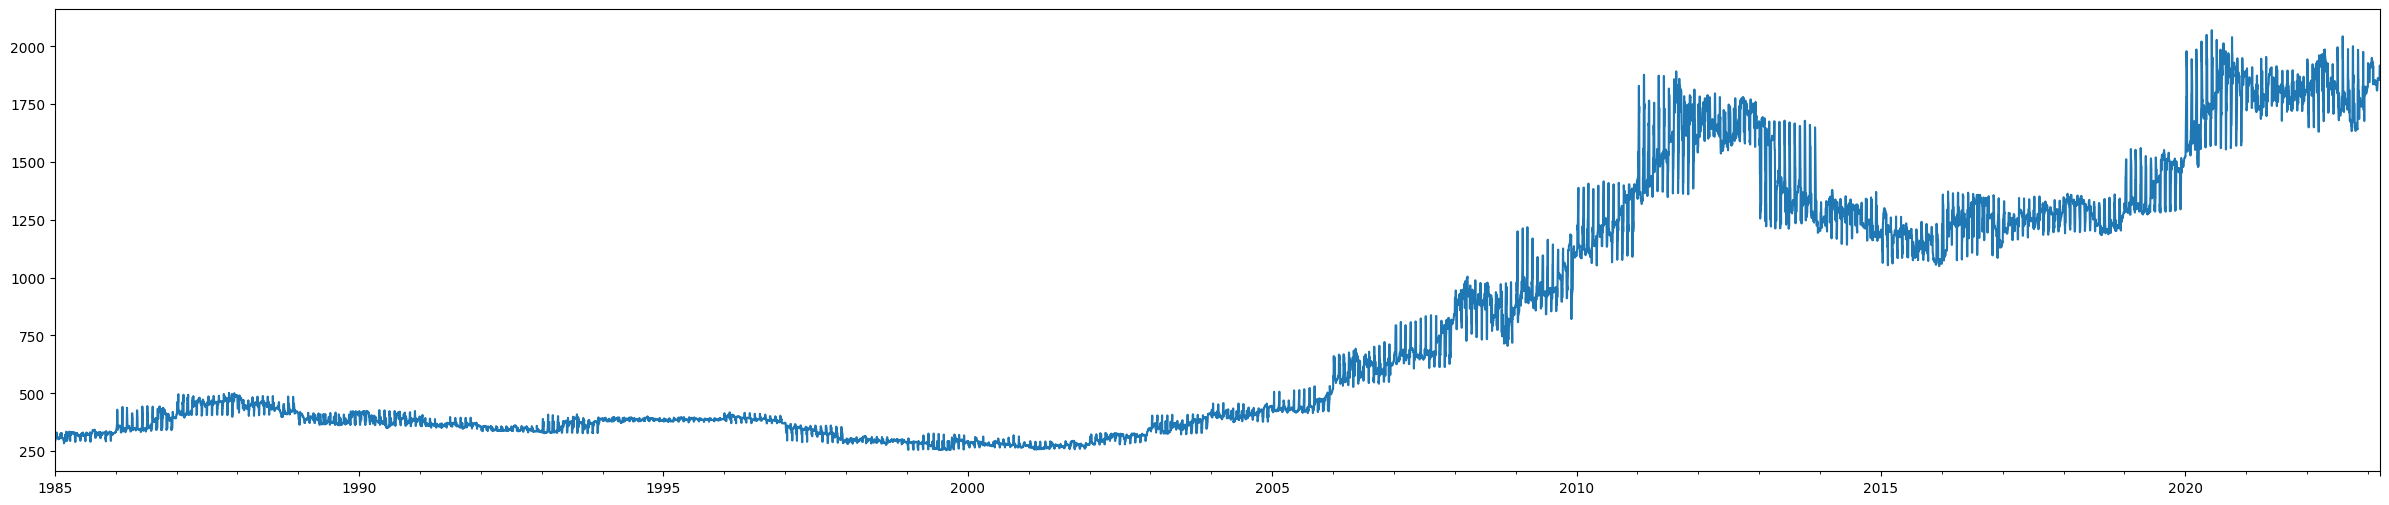

In [66]:
# Plot All values per Year
price_data.plot(figsize=(30,6)).autoscale(axis='x',tight=True)

### Change Data to Rupiah and 1gr Gold Price

In [81]:
price_data_rupiah = (price_data/28.3495)*14687
pd.DataFrame(price_data_rupiah).tail()

,Price
2023-03-10,960810.956102
2023-03-11,960810.956102
2023-03-12,960810.956102
2023-03-13,992879.433500
2023-03-14,992594.495494


### Skala data

In [87]:
# Skala Data
skala_data = price_data_rupiah.max()-price_data_rupiah.min()
print('Skala Data: ', skala_data)

Skala Data:  940658.0680435281


### Normalization

In [89]:
scaler = MinMaxScaler(feature_range=(0,1))
price_data_rupiah_arr = np.array(price_data_rupiah)
price_data_rupiah_norm = scaler.fit_transform(price_data_rupiah_arr.reshape(-1,1))

### Split data (train: 80%, val: 20%)

In [91]:
train_size = int(len(price_data_rupiah_norm) * 0.80)
val_size = len(price_data_rupiah_norm) - train_size

In [92]:
train_size, val_size

(11161, 2791)

In [93]:
train_data = price_data_rupiah_norm[0:train_size,:] 
val_data  = price_data_rupiah_norm[train_size:len(price_data_rupiah_norm),:1]

### Create label from window/timestep (100 timestep)

In [94]:
def createWindowDataset(dataset, time_step = 1):
  X = []
  y = []
  for i in range(len(dataset) - time_step - 1):
    fitur = dataset[i:(i+time_step), 0] # sederet fitur sebelum output timeseries
    X.append(fitur)
    y.append(dataset[i + time_step, 0]) # output data time series
  return np.array(X), np.array(y)

In [100]:
X_train, y_train = createWindowDataset(train_data, 100)
X_val, y_val = createWindowDataset(val_data, 100)

# Check Shape of X_train
print("Shape X_train: ", X_train.shape)
print("Shape X_val: ", X_train.shape)
print("Shape y_val: ", y_train.shape)
print("Shape y_val: ", y_train.shape)


Shape X_train:  (11060, 100)
Shape X_val:  (11060, 100)
Shape y_val:  (11060,)
Shape y_val:  (11060,)


### Reshape data for Training Model LSTM 

In [101]:
#reshape input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Check Shape of X_train
print("Shape X_train: ", X_train.shape)
print("Shape X_val: ", X_train.shape)
print("Shape y_val: ", y_train.shape)
print("Shape y_val: ", y_train.shape)

Shape X_train:  (11060, 100, 1)
Shape X_val:  (11060, 100, 1)
Shape y_val:  (11060,)
Shape y_val:  (11060,)


### Model Building

In [102]:
model = tf.keras.models.Sequential([
            LSTM(60, return_sequences=True),
            LSTM(60),
            Dense(30, activation="relu"),
            Dense(10, activation="relu"),
            Dense(1),
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

### Callback Setting

In [22]:
# Create Callback

# 1 Callback untuk mendapatkan checkpoint setiap akurasi yang membaik dari tiap epoch
checkpoint_filepath = '/content/weights-improvement-{epoch:02d}-{val_mae:.2f}.hdf5'
checkpointCallback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_mae',
                                            mode='min',
                                            save_best_only=True)z

# 2 Callback untuk menghentikan proses training pada rentang akurasi tertentu (di-set 100%)
class stopTrainingCallback(Callback):
  def on_epoch_end(self, epoch,logs={}):
    # Tidak memakai skala data (sebesar 45) karena nanti epoch yang di training hanya sedikit
    if ((logs.get('mae') <= 0.002) and (logs.get('val_mae') <= 0.002)) :
      print('\n Yeyy mae mencapai nilai kurang dari 0.002 🤩')
      self.model.stop_training = True

# 3 Callback mendapatkan accuracy, loss, val_loss, val_accuracy dan disimpan pada csv
log_csv = CSVLogger('prediction_generalelectric_result.csv', separator=';', append=False)

In [23]:
callback_list = [checkpointCallback, stopTrainingCallback(), log_csv]

### Model Training

In [24]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=100, batch_size=256, callbacks=callback_list)

Epoch 1/100


2023-05-11 07:32:23.479424: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/44 [=========>....................] - ETA: 7s - loss: nan - mae: nan 

KeyboardInterrupt: 

In [ ]:
# Show history of mae training model
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Show history of loss training model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()